In [1]:
#本作業包含 Dash 互動圈選功能，請執行最後一個 Cell，即可開啟互動網頁於瀏覽器。若遇 127.0.0.1 拒絕連線，請重新執行所有 Cell 啟動伺服器。
print("請執行最後一個 cell（Dash App 啟動），打開互動式圈選圖。若連不上，請點選上方 Restart → Run All。")

請執行最後一個 cell（Dash App 啟動），打開互動式圈選圖。若連不上，請點選上方 Restart → Run All。


In [2]:
#匯入套件與建立資料集
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import truncnorm
import random
import warnings
warnings.filterwarnings("ignore")

np.random.seed(42) # truncated normal(truncated normal 的數值會固定（來自 numpy）)
random.seed(42) # 產生 quantity = random.randint(...)(每個 quantity 也會固定（來自 random.randint）)


In [3]:
#自訂 truncated normal 函數與 Drink 類別表
def get_truncnorm_samples(mu, sigma, low, high, size):
    a, b = (low - mu) / sigma, (high - mu) / sigma
    return truncnorm.rvs(a, b, loc=mu, scale=sigma, size=size)


# Drink 資訊：Drink 類別、類型群組（Soda/Coffee）、其他屬性
drink_info = [
    ['A', 'Coke',        'Soda', 8, (100, 200), (500, 1000), 100],
    ['B', 'Pepsi',       'Soda', 7, (200, 10),  (500, 1000), 200],
    ['C', 'Sprite',      'Soda', 6, (200, 10),  (500, 1000), 100],
    ['D', '7Up',         'Soda', 5, (400, 100), (500, 1000), 400],
    ['E', 'Cappuccino',  'Coffee', 4, (700, 10), (1, 500),   400],
    ['F', 'Espresso',    'Coffee', 3, (700, 10), (1, 500),   200],
    ['G', 'Latte',       'Coffee', 2, (800, 300), (1, 500),  100],
    ['H', 'Mocha',       'Coffee', 1, (900, 400), (1, 500),  100],
]


In [4]:
#建立 DataFrame（包含手動 Drink 相似度）
rows = []
for c, drink, group, rank, (mu, sigma), (q_low, q_high), count in drink_info:
    for _ in range(count):
        amount = get_truncnorm_samples(mu, sigma, mu-3*sigma, mu+3*sigma, 1)[0]
        quantity = random.randint(q_low, q_high)
        rows.append([c, drink, group, rank, amount, quantity])

df = pd.DataFrame(rows, columns=["Class", "Drink", "Group", "Rank", "Amount", "Quantity"])


In [5]:
#建立名目型 Drink 相似度（轉為距離）矩陣
# 類別間距離設為：同群0、不同群2
drink_names = df["Drink"].unique()
drink_groups = df.drop_duplicates("Drink")[["Drink", "Group"]].set_index("Drink")["Group"]

similarity_matrix = []
for d1 in drink_names:
    row = []
    for d2 in drink_names:
        if drink_groups[d1] == drink_groups[d2]:
            row.append(0.0)  # 相同群
        else:
            row.append(2.0)  # 不同群
    similarity_matrix.append(row)

drink_distance_df = pd.DataFrame(similarity_matrix, index=drink_names, columns=drink_names)


In [6]:
#將 Drink 距離轉為向量編碼並合併數值欄位
# 每筆 Drink 資料 → 對其他 Drink 的距離向量
def encode_drink(drink):
    return drink_distance_df.loc[drink].values

drink_vectors = np.vstack(df["Drink"].apply(encode_drink))
features = np.hstack([
    drink_vectors,
    MinMaxScaler().fit_transform(df[["Rank", "Amount", "Quantity"]])
])


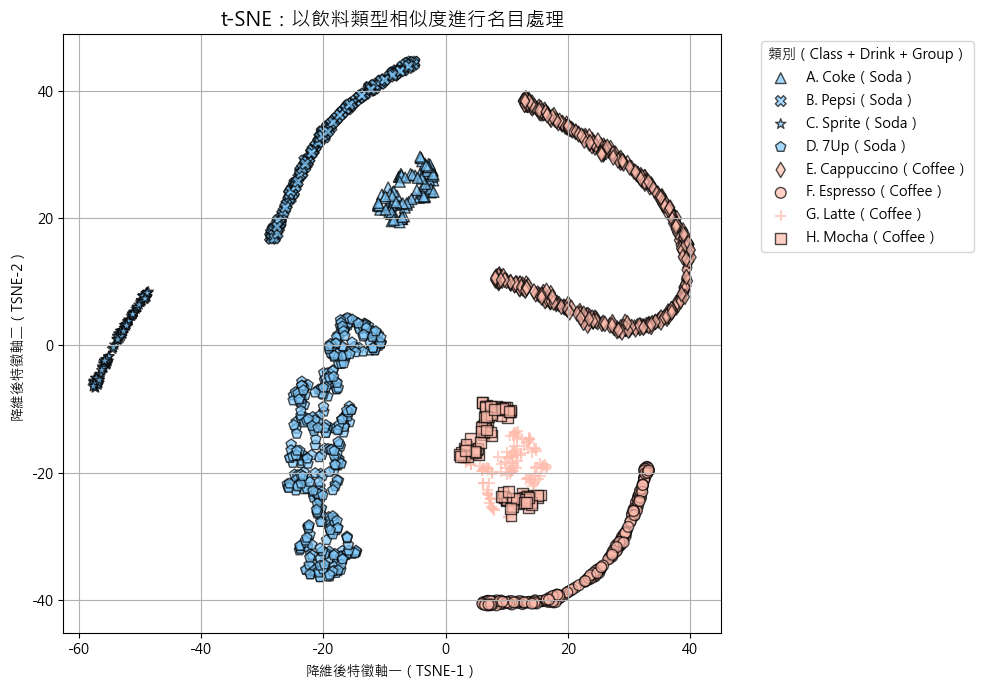

In [7]:
#t-SNE 降維與視覺化


# 設定中文字型
plt.rcParams['font.family'] = 'Microsoft JhengHei' 
plt.rcParams['axes.unicode_minus'] = False

# 配色與標記
color_palette = {
    'Soda': '#82cafc',    # 藍
    'Coffee': '#ffbcad'   # 粉
}

markers = {
    'A': '^', 'B': 'X', 'C': '*', 'D': 'p',  # Soda 系列
    'E': 'd', 'F': 'o', 'G': '+', 'H': 's'   # Coffee 系列
}

# 執行 t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42) # random_state=42 讓 t-SNE 結果穩定不變。
tsne_result = tsne.fit_transform(features)

df["TSNE-1"] = tsne_result[:, 0]
df["TSNE-2"] = tsne_result[:, 1]

# 加這行：建立新的圖例標籤
df["ClassLabel"] = df["Class"] + ". " + df["Drink"] + "（" + df["Group"] + "）"

# 繪圖
plt.figure(figsize=(10, 7))
for cls in df["Class"].unique():
    subset = df[df["Class"] == cls]
    plt.scatter(
        subset["TSNE-1"], subset["TSNE-2"],
        c=[color_palette[g] for g in subset["Group"]],
        marker=markers[cls],
        label=subset["ClassLabel"].iloc[0],  # ✅ 顯示完整名稱
        edgecolors='k', s=60, alpha=0.7
    )

plt.title("t-SNE：以飲料類型相似度進行名目處理", fontsize=14)
plt.xlabel("降維後特徵軸一（TSNE-1）")
plt.ylabel("降維後特徵軸二（TSNE-2）")
plt.legend(title="類別（Class + Drink + Group）", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()



In [8]:
from jupyter_dash import JupyterDash
from dash import dcc, html, Input, Output
import plotly.express as px

# 建立 ClassLabel 欄位（顯示完整圖例名稱）
df["ClassLabel"] = df["Class"] + ". " + df["Drink"] + "（" + df["Group"] + "）"

color_map = {
    'Soda': '#82cafc',
    'Coffee': '#ffbcad'
}
symbol_map = {
    'A': 'triangle-up',
    'B': 'x',
    'C': 'star',
    'D': 'pentagon',
    'E': 'diamond',
    'F': 'circle',
    'G': 'cross',
    'H': 'square'
}

# 建圖
fig = px.scatter(
    df, x="TSNE-1", y="TSNE-2",
    color="Group", symbol="ClassLabel",  # ✅ 使用 ClassLabel
    color_discrete_map=color_map,
    symbol_map=symbol_map,
    hover_data=["Drink", "Group", "Class"]
)

fig.update_traces(
    marker=dict(
        size=10,
        line=dict(width=1, color='black')
    )
)
fig.update_layout(
    height=600,
    width=1000,
    title="t-SNE Dash 互動圈選（以相似度進行名目處理）",
    legend_title="Group, ClassLabel",
    plot_bgcolor="#f9f9f9"
)

# Dash App
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H3("t-SNE Dash 互動圈選（以相似度進行名目處理）"),
    dcc.Graph(id='tsne-scatter', figure=fig),
    html.H4("選取結果："),
    html.Pre(id='selected-data', style={'whiteSpace': 'pre-wrap'})
])

@app.callback(
    Output('selected-data', 'children'),
    Input('tsne-scatter', 'selectedData')
)
def display_selected_data(selectedData):
    if selectedData is None:
        return "請使用 Lasso 或 Box 工具圈選資料點..."
    indices = [pt["pointIndex"] for pt in selectedData["points"]]
    selected = df.iloc[indices]
    return selected[["Class", "Drink", "Group", "TSNE-1", "TSNE-2"]].to_string(index=False)

# 啟動 Dash
app.run_server(mode='external', port=8060)


Dash app running on http://127.0.0.1:8060/
